In [1]:
!python -V

Python 3.9.20


In [1]:
import pandas as pd

In [2]:
import pickle
import mlflow

In [3]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("taxi-duration")

<Experiment: artifact_location='/workspaces/MlopsDatatalksclub/mlruns/1', creation_time=1732254192481, experiment_id='1', last_update_time=1732254192481, lifecycle_stage='active', name='taxi-duration', tags={}>

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [7]:
df = pd.read_parquet('./data/green_tripdata_2024-08.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [7]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.775464208836793

/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ubuntu/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


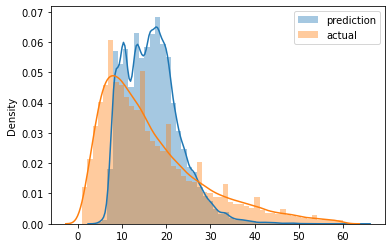

In [8]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [8]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [9]:
df_train = read_dataframe('./data/green_tripdata_2024-08.parquet')
df_val = read_dataframe('./data/green_tripdata_2024-09.parquet')

In [10]:
len(df_train), len(df_val)

(49283, 51690)

In [11]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [12]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [19]:
train_dicts

[{'PU_DO': '65_228', 'trip_distance': 2.85},
 {'PU_DO': '74_74', 'trip_distance': 0.58},
 {'PU_DO': '129_83', 'trip_distance': 1.54},
 {'PU_DO': '66_90', 'trip_distance': 4.57},
 {'PU_DO': '129_112', 'trip_distance': 3.63},
 {'PU_DO': '75_74', 'trip_distance': 1.72},
 {'PU_DO': '65_49', 'trip_distance': 0.0},
 {'PU_DO': '65_181', 'trip_distance': 0.0},
 {'PU_DO': '82_56', 'trip_distance': 0.0},
 {'PU_DO': '74_263', 'trip_distance': 1.45},
 {'PU_DO': '65_89', 'trip_distance': 3.93},
 {'PU_DO': '75_151', 'trip_distance': 1.42},
 {'PU_DO': '25_100', 'trip_distance': 7.26},
 {'PU_DO': '74_262', 'trip_distance': 2.18},
 {'PU_DO': '65_195', 'trip_distance': 1.95},
 {'PU_DO': '130_205', 'trip_distance': 3.74},
 {'PU_DO': '75_235', 'trip_distance': 5.72},
 {'PU_DO': '95_82', 'trip_distance': 2.97},
 {'PU_DO': '42_41', 'trip_distance': 1.14},
 {'PU_DO': '210_210', 'trip_distance': 0.9},
 {'PU_DO': '74_75', 'trip_distance': 1.34},
 {'PU_DO': '25_195', 'trip_distance': 2.18},
 {'PU_DO': '82_157',

In [13]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

np.float64(6.770484835205128)

In [25]:
with open("models/preprocessor.b", "wb") as f:
    pickle.dump(dv, f)

In [21]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [23]:
with mlflow.start_run():
    
    alpha = 0.01
    
    mlflow.set_tag("developer", "sharath")
    mlflow.log_param("alpha",alpha)
    mlflow.log_param("train_data_path","./data/green_tripdata_2024-08.parquet")
    mlflow.log_param("test_data_path", "./data/green_tripdata_2024-09.parquet")
    
    lr = Lasso(alpha)

    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)

    mlflow.log_metric("rmse", rmse)

In [18]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [20]:
train = xgb.DMatrix(X_train, label = y_train)
validation = xgb.DMatrix(X_val, label = y_val)

In [ ]:
def model(params):

    with mlflow.start_run():

        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(params = params, dtrain = train,
                            num_boost_round = 100,
                            evals = [(validation,"valid")],
                            early_stopping_rounds = 10)
        
        y_pred = booster.predict(validation)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)
        mlflow.xgboost.log_model(booster, "model_artifact")
        mlflow.xgboost.autolog()
        mlflow.log_artifact("models/preprocessor.b", "preprocessor")
        return {'loss': rmse, 'status': STATUS_OK}

In [23]:
params ={ "learning_rate":
0.37110078267561053,
"max_depth":
71,
"min_child_weight":
3.0,
"objective":
"reg:linear",
"reg_alpha":
0.07345496693988263,
"reg_lambda":
0.01069576857532707,
"seed":
42}

In [26]:
model(params)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:44:50] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	valid-rmse:7.92477
[1]	valid-rmse:6.84729
[2]	valid-rmse:6.35911
[3]	valid-rmse:6.14285
[4]	valid-rmse:6.05021
[5]	valid-rmse:6.01183
[6]	valid-rmse:5.99062
[7]	valid-rmse:5.97773
[8]	valid-rmse:5.97096
[9]	valid-rmse:5.96573
[10]	valid-rmse:5.96301
[11]	valid-rmse:5.95854
[12]	valid-rmse:5.95798
[13]	valid-rmse:5.95633
[14]	valid-rmse:5.95645
[15]	valid-rmse:5.95617
[16]	valid-rmse:5.95450
[17]	valid-rmse:5.95376
[18]	valid-rmse:5.95108
[19]	valid-rmse:5.94922
[20]	valid-rmse:5.94846
[21]	valid-rmse:5.94833
[22]	valid-rmse:5.94812
[23]	valid-rmse:5.94571
[24]	valid-rmse:5.94622
[25]	valid-rmse:5.94748
[26]	valid-rmse:5.94666
[27]	valid-rmse:5.94666
[28]	valid-rmse:5.94650
[29]	valid-rmse:5.94672
[30]	valid-rmse:5.94577
[31]	valid-rmse:5.94694
[32]	valid-rmse:5.94760


2024/12/01 16:45:10 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/12/01 16:45:10 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:45:10] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2024/12/01 16:45:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:45:13] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as

{'loss': np.float64(5.947866396898716), 'status': 'ok'}

In [16]:
search_space = {
        
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        'max_depth':  scope.int(hp.quniform("max_depth", 4, 100, 1)),
        "learning_rate": hp.loguniform("learning_rate", -3, 0),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        
        "reg_alpha": hp.loguniform("reg_alpha", -5, -1),
        "reg_lambda": hp.loguniform("reg_lambda", -7, -2),
        'objective': 'reg:linear',
        # Increase this number if you have more cores. Otherwise, remove it and it will default 
        # to the maxium number. 
        
        'seed': 42
    }

In [17]:
best = fmin(model, search_space, algo=tpe.suggest, 
                trials=Trials(), 
                max_evals= 2)

  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:57:00] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	valid-rmse:7.92477                               
[1]	valid-rmse:6.84729                               
[2]	valid-rmse:6.35911                               
[3]	valid-rmse:6.14285                               
[4]	valid-rmse:6.05021                               
[5]	valid-rmse:6.01183                               
[6]	valid-rmse:5.99062                               
[7]	valid-rmse:5.97773                               
[8]	valid-rmse:5.97096                               
[9]	valid-rmse:5.96573                               
[10]	valid-rmse:5.96301                              
[11]	valid-rmse:5.95854                              
[12]	valid-rmse:5.95798                              
[13]	valid-rmse:5.95633                              
[14]	valid-rmse:5.95645                              
[15]	valid-rmse:5.95617                              
[16]	valid-rmse:5.95450                              
[17]	valid-rmse:5.95376                              
[18]	valid-rmse:5.95108     

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:57:12] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	valid-rmse:8.92201                                                        
[1]	valid-rmse:8.04960                                                        
[2]	valid-rmse:7.43515                                                        
[3]	valid-rmse:7.01326                                                        
[4]	valid-rmse:6.70474                                                        
[5]	valid-rmse:6.51742                                                        
[6]	valid-rmse:6.39865                                                        
[7]	valid-rmse:6.31064                                                        
[8]	valid-rmse:6.24698                                                        
[9]	valid-rmse:6.21400                                                        
[10]	valid-rmse:6.17783                                                       
[11]	valid-rmse:6.16105                                                       
[12]	valid-rmse:6.14437                             